## Imports

In [102]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
import seaborn as sns

from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from utilities import df_utils

RANDOM_STATE = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preprocessing

In [30]:
features = pd.read_csv('../data/features.csv', index_col=0)
df_utils.df_summarise(features)

(16599, 13)

Index(['customer_id', 'makes_purchase', 'last_transaction_date', 'recency',
       'recency_score', 'frequency', 'frequency_score', 'total_revenue',
       'total_revenue_score', 'rfm_score', 'rfm_segment', 'billing_zip_stem',
       'segment'],
      dtype='object')

,customer_id,makes_purchase,last_transaction_date,recency,recency_score,frequency,frequency_score,total_revenue,total_revenue_score,rfm_score,rfm_segment,billing_zip_stem,segment
0,3493717180478,0,2020-10-01 12:46:56,271,0,1,0,2445.00,1,1,low,87,3
1,3493777768510,0,2020-10-01 13:32:38,271,0,1,0,448.00,0,0,low,50,3
2,3490993078334,0,2020-10-01 13:38:06,271,0,1,0,2293.60,1,1,low,60,3
3,3433191145534,0,2020-10-01 14:28:48,271,0,1,0,438.95,0,0,low,28,3
4,3494350880830,0,2020-10-01 21:11:57,271,0,1,0,399.05,0,0,low,26,3


cat

In [ ]:
categorical_cols = [
    'recency_score', 'frequency_score', 'total_revenue_score', 
    'rfm_score', 'rfm_segment', 'billing_zip_stem', 'segment'
    ]
categorical_features = pd.get_dummies(
    features[categorical_cols].astype(str),
    drop_first=True
    )

num

In [59]:
numerical_cols = ['recency', 'frequency', 'total_revenue']
numerical_features = features[numerical_cols].copy()
normalised_features = preprocessing.normalize(numerical_features)
for idx, col in enumerate(numerical_cols):
    numerical_features[col] = normalised_features[:, idx]

In [60]:
model_features = pd.concat((
    numerical_features,
    categorical_features
    ), 
    axis=1)

df_utils.df_summarise(model_features)

(16599, 141)

Index(['recency', 'frequency', 'total_revenue', 'recency_score_1',
       'recency_score_2', 'recency_score_3', 'frequency_score_1',
       'frequency_score_2', 'frequency_score_3', 'total_revenue_score_1',
       ...
       'billing_zip_stem_SW40JW', 'billing_zip_stem_VALBY',
       'billing_zip_stem_nan', 'segment_10', 'segment_11', 'segment_3',
       'segment_4', 'segment_6', 'segment_7', 'segment_9'],
      dtype='object', length=141)

,recency,frequency,total_revenue,recency_score_1,recency_score_2,recency_score_3,frequency_score_1,frequency_score_2,frequency_score_3,total_revenue_score_1,...,billing_zip_stem_SW40JW,billing_zip_stem_VALBY,billing_zip_stem_nan,segment_10,segment_11,segment_3,segment_4,segment_6,segment_7,segment_9
0,0.110164,0.000407,0.993913,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.517581,0.001910,0.855632,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.117339,0.000433,0.993092,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.525329,0.001938,0.850897,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.561807,0.002073,0.827266,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Model training

In [61]:
models = {
    'logistic_regression': LogisticRegression(),
    'naive_bayes': GaussianNB(),
    'random_forest': RandomForestClassifier(),
    'xgb': xgb.XGBClassifier(use_label_encoder=False),
    'knn': KNeighborsClassifier(),
}

In [62]:
train_features, val_features, train_target, val_target = train_test_split(model_features, features['makes_purchase'], test_size=0.2, random_state=RANDOM_STATE)

for model_name, model in models.items():
    kfold = KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
    result = cross_val_score(model, train_features, train_target, cv=kfold, scoring='f1')
    print(model_name, result, f'average score: {np.mean(result):.1%}')

logistic_regression [0.18518519 0.15625    0.03703704] average score: 12.6%
naive_bayes [0.02059925 0.02469845 0.02122498] average score: 2.2%
random_forest [0.21052632 0.19354839 0.07272727] average score: 15.9%
[22:37:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb [0.27692308 0.34210526 0.17

In [64]:
parameters = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2),
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=parameters,
    scoring='f1',
    n_jobs=-1,
    cv=2
    )

grid_search.fit(train_features, train_target)
grid_search.best_params_, grid_search.best_score_


/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:45:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 9, 'min_child_weight': 1}, 0.2386083743842365)

## Evaluation

In [70]:
xgb_model = xgb.XGBClassifier(max_depth=9, min_child_weight=1).fit(train_features, train_target)
xgb_model.score(val_features, val_target)

[22:50:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9903614457831326

In [78]:
val_predictions = xgb_model.predict(val_features)
f1_score(val_target, val_predictions)

0.3846153846153846

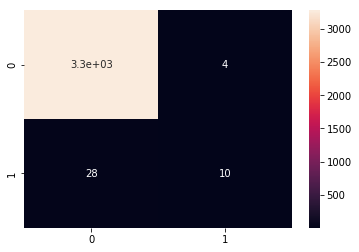

In [81]:
sns.heatmap(confusion_matrix(val_target, val_predictions), annot=True);

**Feature importance**

In [103]:
def show_feature_importance(
        feature_importances: ndarray, 
        model_features: DataFrame, 
        top_features: int = 10
        ) -> None:
    """
    Displays feature importance results
    """
    mapped_feature_importances = [
        (feature_name, feature_importance ) 
        for feature_name, feature_importance in zip(model_features.columns, feature_importances)
        ]
    sorted_feature_importances = sorted(mapped_feature_importances, key=lambda x: x[1], reverse=True)[:top_features]

    for feature_name, feature_score in sorted_feature_importances:
        print(f'{feature_name}: {feature_score:.2f}')

    top_feature_names = [feature[0] for feature in sorted_feature_importances]
    top_feature_scores = [feature[1] for feature in sorted_feature_importances]

    plt.figure(figsize=(20,10))
    plt.barh(range(len(top_feature_scores)), top_feature_scores)
    plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
    plt.show()

Model:

segment_3: 0.14
recency_score_3: 0.08
rfm_score_2: 0.06
recency_score_1: 0.05
recency_score_2: 0.05
segment_11: 0.04
segment_7: 0.03
billing_zip_stem_84: 0.02
frequency_score_1: 0.02
rfm_score_7: 0.02


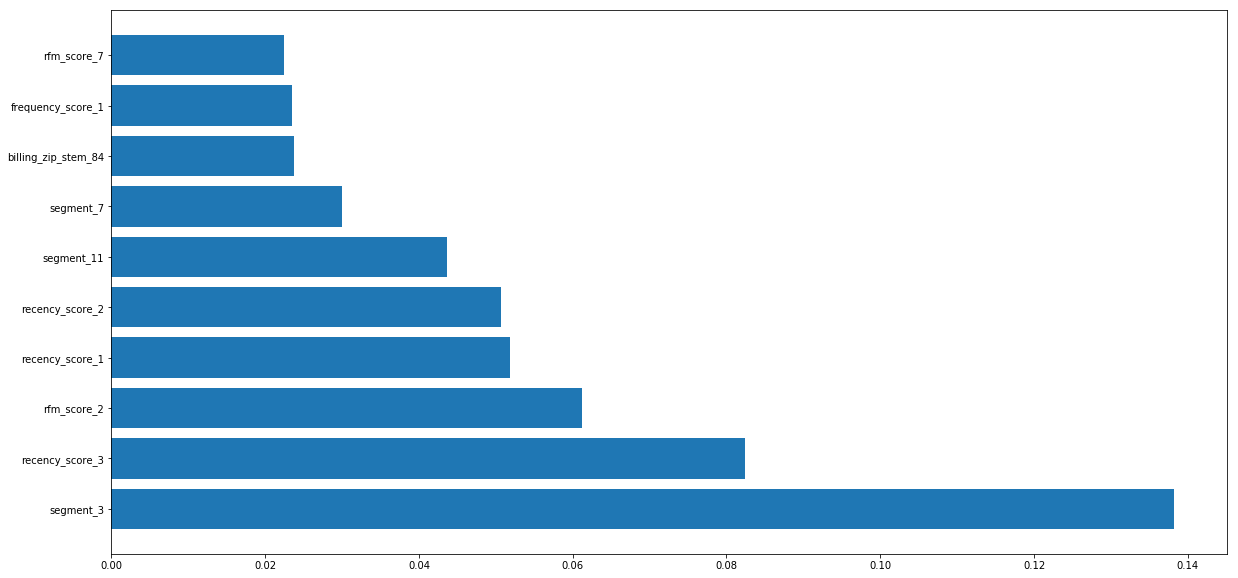

In [104]:
feature_importances = xgb_model.feature_importances_
show_feature_importance(feature_importances, model_features)


Permutation:

segment_11: 0.26
segment_3: 0.21
recency: 0.14
frequency: 0.14
recency_score_3: 0.08
rfm_score_4: 0.06
billing_zip_stem_30: 0.06
recency_score_2: 0.05
segment_6: 0.05
rfm_score_2: 0.04


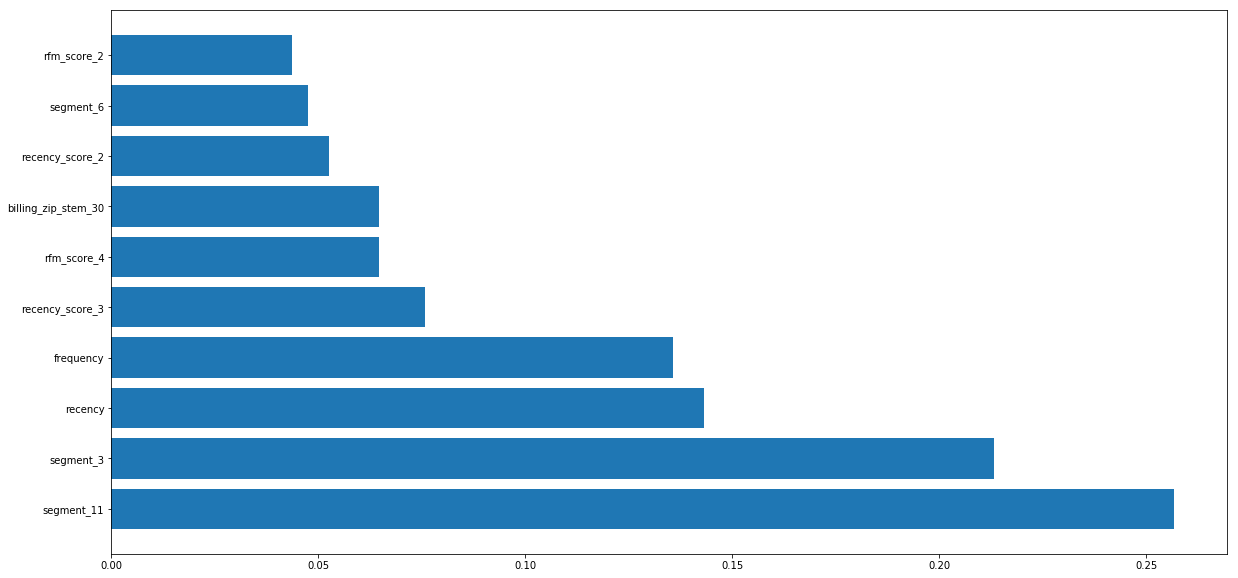

In [100]:
results = permutation_importance(xgb_model, val_features, val_target, scoring='f1')
feature_importances = results.importances_mean
show_feature_importance(feature_importances, model_features)